In [1]:
"""
Finding matching ICS records for NIFC perimeters.

Author: maxwell.cook@colorado.edu
"""

import os, sys
import geopandas as gpd
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.cm as cm
import matplotlib.colors as colors

from scipy.spatial import cKDTree
from shapely.geometry import Point

# Custom functions
sys.path.append(os.path.join(os.getcwd(),'code/'))
from __functions import *

proj = 'EPSG:5070'

maindir = '/Users/max/Library/CloudStorage/OneDrive-Personal/mcook/'
projdir = os.path.join(maindir, 'aspen-fire/Aim2/')
icsdir = os.path.join(maindir, 'ics209-plus-fired/data/')

print("Ready !")

Ready !


In [2]:
# Load some boundary data
states = os.path.join(maindir, 'data/boundaries/political/TIGER/tl19_us_states_w_ak_lambert.gpkg')
states = gpd.read_file(states)
states = states.to_crs(proj)
states.columns

Index(['REGION', 'DIVISION', 'STATEFP', 'STATENS', 'GEOID', 'STUSPS', 'NAME',
       'LSAD', 'MTFCC', 'FUNCSTAT', 'ALAND', 'AWATER', 'INTPTLAT', 'INTPTLON',
       'geometry'],
      dtype='object')

In [3]:
# Load the wildfire dataset
inci_path = os.path.join(icsdir, 'tabular/raw/wf-incidents/ics209-plus_v3.2/ics209-plus-wf_incidents_1999to2023.csv')
incidents = pd.read_csv(inci_path, low_memory=False)
incidents.columns

Index(['Unnamed: 0', 'INCIDENT_ID', 'INCIDENT_NUMBER', 'INCIDENT_NAME',
       'INCTYP_ABBREVIATION', 'FINAL_ACRES', 'CAUSE', 'COMPLEX',
       'DISCOVERY_DATE', 'DISCOVERY_DOY', 'EXPECTED_CONTAINMENT_DATE',
       'FATALITIES', 'FUEL_MODEL', 'INCIDENT_DESCRIPTION', 'INC_IDENTIFIER',
       'INJURIES_TOTAL', 'LL_CONFIDENCE', 'LL_UPDATE', 'LOCAL_TIMEZONE',
       'POO_CITY', 'POO_COUNTY', 'POO_LATITUDE', 'POO_LONGITUDE',
       'POO_SHORT_LOCATION_DESC', 'POO_STATE', 'PROJECTED_FINAL_IM_COST',
       'START_YEAR', 'SUPPRESSION_METHOD', 'STR_DAMAGED_TOTAL',
       'STR_DAMAGED_COMM_TOTAL', 'STR_DAMAGED_RES_TOTAL',
       'STR_DESTROYED_TOTAL', 'STR_DESTROYED_COMM_TOTAL',
       'STR_DESTROYED_RES_TOTAL', 'FATALITIES_RESPONDER', 'FATALITIES_PUBLIC',
       'FINAL_REPORT_DATE', 'INCIDENT_ID_OLD', 'INC_MGMT_NUM_SITREPS',
       'EVACUATION_REPORTED', 'PEAK_EVACUATIONS', 'STR_THREATENED_MAX',
       'STR_THREATENED_COMM_MAX', 'STR_THREATENED_RES_MAX', 'TOTAL_AERIAL_SUM',
       'TOTAL_PERSON

In [4]:
# Tidy the columns
incidents.dropna(subset=['DISCOVERY_DATE'], inplace=True)
incidents['DISCOVERY_DATE'] = pd.to_datetime(incidents['DISCOVERY_DATE'])
incidents['START_YEAR'] = incidents['DISCOVERY_DATE'].dt.year
incidents['START_YEAR'] = incidents['START_YEAR'].astype(int)

# Filter to match NIFC fire years (2018 to 2023)
incidents = incidents[incidents['START_YEAR'] >= 2018]
print(f"There are [{len(incidents)}] ICS-209-PLUS incidents (2018-2023).")

There are [8653] ICS-209-PLUS incidents (2018-2023).


In [5]:
# Create a spatial points data from the ICS-209-PLUS records
geometry = [Point(xy) for xy in zip(incidents['POO_LONGITUDE'], incidents['POO_LATITUDE'])]

# Create a GeoDataFrame
incidents_gdf = gpd.GeoDataFrame(incidents, geometry=geometry)
incidents_gdf = incidents_gdf.set_crs(epsg=4326, inplace=True) # set the crs
incidents_gdf = incidents_gdf.to_crs(proj) # reproject to EPSG:5070

print(f"There are [{len(incidents_gdf)}] spatial points (2018-2023).")

There are [8653] spatial points (2018-2023).


In [6]:
# Intersect with state boundaries and match with POO_STATE
incidents_gdf = gpd.sjoin(incidents_gdf, states[['geometry', 'STUSPS']], how='inner', predicate='intersects')
incidents_gdf = incidents_gdf[incidents_gdf['POO_STATE'] == incidents_gdf['STUSPS']] # filter where states match
print(f"There are [{len(incidents_gdf)}] spatial points matching state of origin (2018-2023).")

There are [8607] spatial points matching state of origin (2018-2023).


In [7]:
# Plot the incident reports.

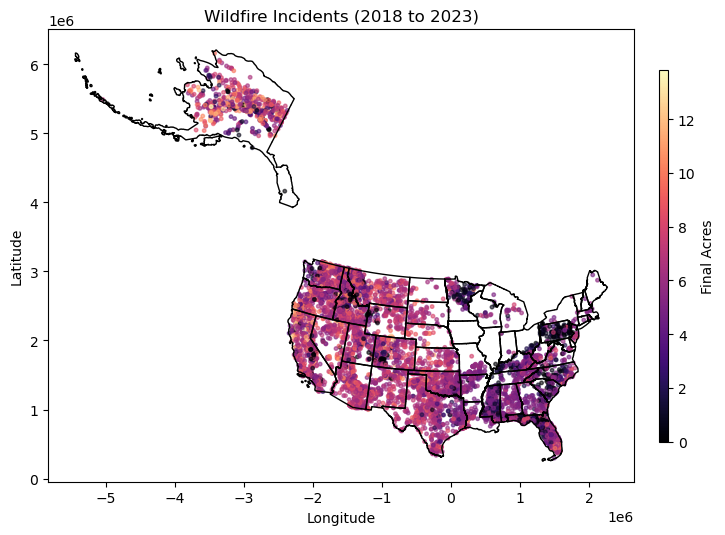

104

In [8]:
# Filter the GeoDataFrame for points in Colorado
gdf = incidents_gdf.copy()
gdf['log_FINAL_ACRS'] = np.log1p(gdf['FINAL_ACRES'])  # log1p to handle log(0) issues

# Plot the points on a map, with size based on FINAL_ACRES
fig, ax = plt.subplots(figsize=(8, 8))

# Normalize the FINAL_ACRES values for color mapping
norm = colors.Normalize(vmin=gdf['log_FINAL_ACRS'].min(), vmax=gdf['log_FINAL_ACRS'].max())

# Plot the points with size and color based on FINAL_ACRES
gdf.plot(ax=ax, marker='o',
         color=gdf['log_FINAL_ACRS'].apply(lambda x: cm.magma(norm(x))),
         alpha=0.6, markersize=6.5)

states.plot(ax=ax, edgecolor='black', linewidth=1, color='none')

# Set title and labels
plt.title('Wildfire Incidents (2018 to 2023)')
plt.xlabel('Longitude')
plt.ylabel('Latitude')

# Add a colorbar
sm = plt.cm.ScalarMappable(cmap='magma', norm=norm)
sm.set_array([])
cbar = plt.colorbar(sm, ax=ax, fraction=0.015, pad=0.04, aspect=40)
cbar.set_label('Final Acres')

# Display the plot
plt.show()

del gdf
gc.collect()

In [9]:
# Subset to western U.S. ecoregions

In [10]:
# Load western U.S. ecoregions
fp = os.path.join(projdir,'data/spatial/raw/boundaries/na_cec_eco_l3_west.gpkg')
ecol3 = gpd.read_file(fp)
ecol3 = ecol3[['NA_L3NAME','geometry']]
ecol3 = ecol3.rename(columns={'NA_L3NAME': 'na_l3name'})
ecol3.columns

Index(['na_l3name', 'geometry'], dtype='object')

In [11]:
# Perform the overlay analysis
incidents_west = gpd.overlay(incidents_gdf, ecol3, how='intersection') # find overlaps
print(f"There are {len(incidents_west)} ICS-209-PLUS incidents across western U.S. ecoregions in CONUS (2018-2023).")

There are 3935 ICS-209-PLUS incidents across western U.S. ecoregions in CONUS (2018-2023).


In [12]:
# Save this file out.

In [13]:
out_dir = os.path.join(projdir, 'data/spatial/raw/ICS209PLUS/')
if not os.path.exists(out_dir):
    os.makedirs(out_dir)
out_file = os.path.join(out_dir, 'wf_incidents_spatial_west_2018to2023.gpkg')
incidents_west.to_file(out_file)
print(f"file exported to {out_file}")

file exported to /Users/max/Library/CloudStorage/OneDrive-Personal/mcook/aspen-fire/Aim2/data/spatial/raw/ICS209PLUS/wf_incidents_spatial_west_2018to2023.gpkg


In [14]:
# Load the NIFC fire perimeters (aspen fires) and find nearest neighbors.

In [15]:
aspen_events_fp = os.path.join(projdir,'data/spatial/mod/NIFC/nifc-interagency_2018_to_2023-TreeMap_aspen.gpkg')
aspen_events = gpd.read_file(aspen_events_fp)
aspen_events['FIRE_YEAR'] = aspen_events['FIRE_YEAR'].astype(int)
aspen_events.columns

Index(['OBJECTID', 'na_l3name', 'MAP_METHOD', 'GEO_ID', 'IRWINID', 'FIRE_YEAR',
       'INCIDENT', 'FEATURE_CA', 'GIS_ACRES', 'pct_cover', 'YEAR_NAME',
       'geometry'],
      dtype='object')

In [16]:
print(incidents_west.crs)
print(aspen_events.crs)

EPSG:5070
EPSG:5070


In [17]:
# Identify matching fired perimiters and ics-209 incident reports
ics_nn, no_matches = find_nearest(
    aspen_events, 
    incidents_west, 
    nn=10, 
    max_dist=10000, 
    max_size_diff=50
)
print(f'Found {len(ics_nn)} matches;')

There were [164/703] fires with no matches.
Found 479 matches;


In [18]:
ics_nn.columns

Index(['Unnamed: 0', 'INCIDENT_ID', 'INCIDENT_NUMBER', 'INCIDENT_NAME',
       'INCTYP_ABBREVIATION', 'FINAL_ACRES', 'CAUSE', 'COMPLEX',
       'DISCOVERY_DATE', 'DISCOVERY_DOY', 'EXPECTED_CONTAINMENT_DATE',
       'FATALITIES', 'FUEL_MODEL', 'INCIDENT_DESCRIPTION', 'INC_IDENTIFIER',
       'INJURIES_TOTAL', 'LL_CONFIDENCE', 'LL_UPDATE', 'LOCAL_TIMEZONE',
       'POO_CITY', 'POO_COUNTY', 'POO_LATITUDE', 'POO_LONGITUDE',
       'POO_SHORT_LOCATION_DESC', 'POO_STATE', 'PROJECTED_FINAL_IM_COST',
       'START_YEAR', 'SUPPRESSION_METHOD', 'STR_DAMAGED_TOTAL',
       'STR_DAMAGED_COMM_TOTAL', 'STR_DAMAGED_RES_TOTAL',
       'STR_DESTROYED_TOTAL', 'STR_DESTROYED_COMM_TOTAL',
       'STR_DESTROYED_RES_TOTAL', 'FATALITIES_RESPONDER', 'FATALITIES_PUBLIC',
       'FINAL_REPORT_DATE', 'INCIDENT_ID_OLD', 'INC_MGMT_NUM_SITREPS',
       'EVACUATION_REPORTED', 'PEAK_EVACUATIONS', 'STR_THREATENED_MAX',
       'STR_THREATENED_COMM_MAX', 'STR_THREATENED_RES_MAX', 'TOTAL_AERIAL_SUM',
       'TOTAL_PERSON

In [19]:
# Create a geodataframe and tidy the columns.
ics_nn_gdf = gpd.GeoDataFrame(ics_nn, geometry='geometry', crs=proj)
ics_nn_gdf = ics_nn_gdf[['NIFC_ID','NIFC_NAME','NIFC_ACRES','INCIDENT_ID','INCIDENT_NAME','START_YEAR','FINAL_ACRES',
                         'CAUSE','DISCOVERY_DATE','DISCOVERY_DOY','WF_CESSATION_DATE','WF_CESSATION_DOY',
                         'STR_DESTROYED_TOTAL','STR_DAMAGED_TOTAL','STR_THREATENED_MAX',
                         'EVACUATION_REPORTED','PEAK_EVACUATIONS','WF_PEAK_AERIAL','WF_PEAK_PERSONNEL',
                         'na_l3name', 'geometry']]
date_cols = ['DISCOVERY_DATE','WF_CESSATION_DATE']
for col in date_cols:
    ics_nn_gdf[col] = pd.to_datetime(ics_nn_gdf[col], errors='coerce')
# Sort by fire size just for exploration
ics_nn_gdf.sort_values(by=['FINAL_ACRES'], ascending=False, inplace=True)
ics_nn_gdf[['NIFC_ID','NIFC_NAME','NIFC_ACRES','INCIDENT_ID','INCIDENT_NAME','START_YEAR','FINAL_ACRES','na_l3name','geometry']].head(10) # the 10 largest fires

,NIFC_ID,NIFC_NAME,NIFC_ACRES,INCIDENT_ID,INCIDENT_NAME,START_YEAR,FINAL_ACRES,na_l3name,geometry
427,49177,Martin,431753.7,2018_9206799_MARTIN,Martin,2018,435569.0,Central Basin and Range,POINT (-1759263.957 2256312.453)
90,13356,Calf Canyon,299792.6,2022_14425222_HERMITS PEAK,Hermits Peak,2022,341735.0,Southern Rockies,POINT (-840734.881 1447835.623)
460,29786,South Sugarloaf,233461.6,2018_9254001_SOUTH SUGARLOAF,South Sugarloaf,2018,233458.0,Northern Basin and Range,POINT (-1663451.871 2268176.527)
129,21169,Cameron Peak,208760.3,2020_11856938_CAMERON PEAK,Cameron Peak,2020,208913.0,Southern Rockies,POINT (-827422.811 1998214.988)
347,42036,East Troublesome,193693.9,2020_11966782_EAST TROUBLESOME,EAST TROUBLESOME,2020,193812.0,Southern Rockies,POINT (-862305.485 1956211.515)
348,42043,Mullen,176787.2,2020_11917747_MULLEN,MULLEN,2020,176878.0,Southern Rockies,POINT (-865749.421 2066257.778)
328,31389,Double Creek,175937.9,2022_14629374_DOUBLE CREEK,Double Creek,2022,171532.0,Blue Mountains,POINT (-1609322.478 2668657.416)
405,82639,Pine Gulch,138802.5,2020_11776240_PINE GULCH,Pine Gulch,2020,139007.0,Colorado Plateaus,POINT (-1066650.101 1882986.505)
78,9657,Moose,130262.7,2022_14482326_MOOSE,Moose,2022,130205.0,Idaho Batholith,POINT (-1408090.243 2621299.548)
447,25177,Spring Creek,108131.3,2018_9201669_SPRING CREEK,Spring Creek,2018,108045.0,Southern Rockies,POINT (-812349.030 1645402.922)


In [20]:
# Check for incident name matches
ics_nn_gdf['NIFC_NAME'] = ics_nn_gdf['NIFC_NAME'].str.upper()
ics_nn_gdf['INCIDENT_NAME'] = ics_nn_gdf['INCIDENT_NAME'].str.upper()
ics_nn_gdf['FIRE_NAME_MATCH'] = ics_nn_gdf['NIFC_NAME'] == ics_nn_gdf['INCIDENT_NAME']
print(f"There are [{ics_nn_gdf['FIRE_NAME_MATCH'].sum()}/{len(ics_nn_gdf)}] matching incidents names !")

There are [449/479] matching incidents names !


In [21]:
out_fp = os.path.join(projdir,'data/spatial/mod/ICS209PLUS/')
if not os.path.exists(out_fp):
    os.makedirs(out_fp)
out_fp = os.path.join(out_fp,'ics209plus_aspen_fires.gpkg')
ics_nn_gdf.to_file(out_fp)
print(f"Saved file to: {out_fp}")

Saved file to: /Users/max/Library/CloudStorage/OneDrive-Personal/mcook/aspen-fire/Aim2/data/spatial/mod/ICS209PLUS/ics209plus_aspen_fires.gpkg


In [22]:
# Save out NIFC fires with ICS matches
matches = ics_nn_gdf['NIFC_ID'].unique()
aspen_events_ = aspen_events[aspen_events['OBJECTID'].isin(matches)]
print(len(aspen_events_))
print(aspen_events_.columns)

479
Index(['OBJECTID', 'na_l3name', 'MAP_METHOD', 'GEO_ID', 'IRWINID', 'FIRE_YEAR',
       'INCIDENT', 'FEATURE_CA', 'GIS_ACRES', 'pct_cover', 'YEAR_NAME',
       'geometry'],
      dtype='object')


In [23]:
ics_nn_gdf.columns

Index(['NIFC_ID', 'NIFC_NAME', 'NIFC_ACRES', 'INCIDENT_ID', 'INCIDENT_NAME',
       'START_YEAR', 'FINAL_ACRES', 'CAUSE', 'DISCOVERY_DATE', 'DISCOVERY_DOY',
       'WF_CESSATION_DATE', 'WF_CESSATION_DOY', 'STR_DESTROYED_TOTAL',
       'STR_DAMAGED_TOTAL', 'STR_THREATENED_MAX', 'EVACUATION_REPORTED',
       'PEAK_EVACUATIONS', 'WF_PEAK_AERIAL', 'WF_PEAK_PERSONNEL', 'na_l3name',
       'geometry', 'FIRE_NAME_MATCH'],
      dtype='object')

In [24]:
# Drop the geometry column from the ICS data
ics_nn_gdf_ = ics_nn_gdf.drop(columns=['FIRE_NAME_MATCH','na_l3name','geometry'])
ics_nn_gdf_.columns

Index(['NIFC_ID', 'NIFC_NAME', 'NIFC_ACRES', 'INCIDENT_ID', 'INCIDENT_NAME',
       'START_YEAR', 'FINAL_ACRES', 'CAUSE', 'DISCOVERY_DATE', 'DISCOVERY_DOY',
       'WF_CESSATION_DATE', 'WF_CESSATION_DOY', 'STR_DESTROYED_TOTAL',
       'STR_DAMAGED_TOTAL', 'STR_THREATENED_MAX', 'EVACUATION_REPORTED',
       'PEAK_EVACUATIONS', 'WF_PEAK_AERIAL', 'WF_PEAK_PERSONNEL'],
      dtype='object')

In [25]:
# Join perimeter data to ICS-209-PLUS
aspen_events_ics = pd.merge(aspen_events_, ics_nn_gdf_, left_on='OBJECTID', right_on='NIFC_ID', how='inner')
aspen_events_ics.columns

Index(['OBJECTID', 'na_l3name', 'MAP_METHOD', 'GEO_ID', 'IRWINID', 'FIRE_YEAR',
       'INCIDENT', 'FEATURE_CA', 'GIS_ACRES', 'pct_cover', 'YEAR_NAME',
       'geometry', 'NIFC_ID', 'NIFC_NAME', 'NIFC_ACRES', 'INCIDENT_ID',
       'INCIDENT_NAME', 'START_YEAR', 'FINAL_ACRES', 'CAUSE', 'DISCOVERY_DATE',
       'DISCOVERY_DOY', 'WF_CESSATION_DATE', 'WF_CESSATION_DOY',
       'STR_DESTROYED_TOTAL', 'STR_DAMAGED_TOTAL', 'STR_THREATENED_MAX',
       'EVACUATION_REPORTED', 'PEAK_EVACUATIONS', 'WF_PEAK_AERIAL',
       'WF_PEAK_PERSONNEL'],
      dtype='object')

In [26]:
# Tidy the columns before export.
aspen_events_ics = aspen_events_ics[[
    'NIFC_ID', 'NIFC_NAME', 'NIFC_ACRES', 'FINAL_ACRES', 'pct_cover',
    'INCIDENT_ID', 'INCIDENT_NAME', 'START_YEAR',  'CAUSE', 
    'DISCOVERY_DATE', 'DISCOVERY_DOY','WF_CESSATION_DATE', 'WF_CESSATION_DOY', 
    'STR_DESTROYED_TOTAL', 'STR_DAMAGED_TOTAL', 'STR_THREATENED_MAX', 
    'EVACUATION_REPORTED', 'PEAK_EVACUATIONS', 'WF_PEAK_AERIAL', 'WF_PEAK_PERSONNEL', 
    'na_l3name', 'geometry']]
aspen_events_ics.head(3)

,NIFC_ID,NIFC_NAME,NIFC_ACRES,FINAL_ACRES,pct_cover,INCIDENT_ID,INCIDENT_NAME,START_YEAR,CAUSE,DISCOVERY_DATE,...,WF_CESSATION_DOY,STR_DESTROYED_TOTAL,STR_DAMAGED_TOTAL,STR_THREATENED_MAX,EVACUATION_REPORTED,PEAK_EVACUATIONS,WF_PEAK_AERIAL,WF_PEAK_PERSONNEL,na_l3name,geometry
0,6,DEVIL CREEK,20.46,20.0,26.963351,2018_9105784_DEVIL CREEK,DEVIL CREEK,2018,L,2018-07-19 15:46:00,...,202.0,0.0,0.0,NaN,NaN,NaN,NaN,15.0,Southern Rockies,"POLYGON ((-982129.078 1645992.166, -982130.062..."
1,8,577,89.31,95.0,3.382762,2019_10730561_577,577,2019,L,2019-07-28 14:22:00,...,230.0,0.0,0.0,NaN,NaN,NaN,5.0,60.0,Southern Rockies,"POLYGON ((-1004794.303 1628941.376, -1004800.7..."
2,14,416,54130.98,54129.0,42.561069,2018_9091030_416,416,2018,U,2018-06-01 11:02:00,...,184.0,0.0,0.0,3386.0,True,2182.0,15.0,429.125,Southern Rockies,"POLYGON ((-1048202.978 1672559.736, -1048208.8..."


In [27]:
# Check geometry type.
print(f"Geometry set to: {aspen_events_ics.geom_type.unique()}")

Geometry set to: ['Polygon' 'MultiPolygon']


In [28]:
out_fp = os.path.join(projdir,'data/spatial/mod/NIFC/nifc-ics_2018_to_2023-aspen.gpkg')
aspen_events_ics.to_file(out_fp)
print(f"Saved file to: {out_fp}")

Saved file to: /Users/max/Library/CloudStorage/OneDrive-Personal/mcook/aspen-fire/Aim2/data/spatial/mod/NIFC/nifc-ics_2018_to_2023-aspen.gpkg


In [29]:
# Create a map.

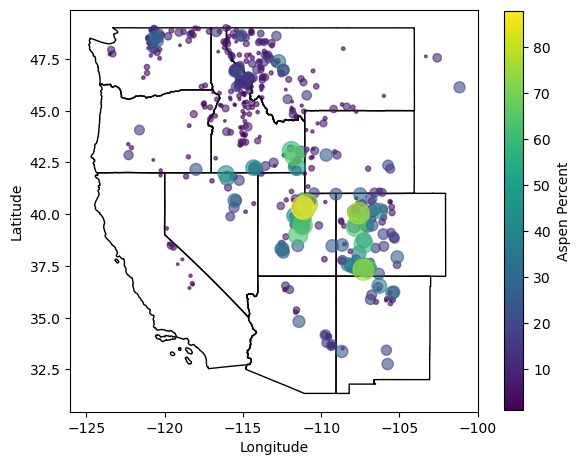

In [30]:
# Load the state boundaries
states = gpd.read_file(os.path.join(maindir,'data/boundaries/political/TIGER/tl19_us_states_west_nad83.gpkg'))
states = states.to_crs(4326)

# Generate centroids
centroid = aspen_events_ics.copy()
centroid = centroid.to_crs(4326)
centroid['geometry'] = centroid.geometry.centroid
centroid['size'] = centroid['pct_cover'] * 3  # Adjust the scaling factor as necessary
centroid = centroid.sort_values(by='pct_cover', ascending=True)

# Make a spatial map of the centroids now
fig, ax = plt.subplots(figsize=(6, 6))

states.plot(ax=ax, edgecolor='black', linewidth=1, color='none')
centroid.plot(
    ax=ax, markersize=centroid['size'], 
    column='pct_cover', cmap='viridis', 
    legend=False, alpha=0.6)

# Manually add colorbar
norm = mpl.colors.Normalize(vmin=centroid['pct_cover'].min(), vmax=centroid['pct_cover'].max())
sm = plt.cm.ScalarMappable(cmap='viridis', norm=norm)
sm.set_array([])  # Only needed for ScalarMappable

# Adjust the size of the colorbar using the `shrink` parameter
cbar = fig.colorbar(sm, ax=ax, shrink=0.7)
cbar.set_label('Aspen Percent')

plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.tight_layout()

# Save the map as a PNG
plt.savefig(os.path.join(projdir, 'figures/Figure1_Aspen-Fires_NIFC-ICS.png'), dpi=300, bbox_inches='tight')

plt.show()

In [31]:
# save a fire perimeter dataset for GEE CBI calculation

In [33]:
aspen_events_ics.columns

Index(['NIFC_ID', 'NIFC_NAME', 'NIFC_ACRES', 'FINAL_ACRES', 'pct_cover',
       'INCIDENT_ID', 'INCIDENT_NAME', 'START_YEAR', 'CAUSE', 'DISCOVERY_DATE',
       'DISCOVERY_DOY', 'WF_CESSATION_DATE', 'WF_CESSATION_DOY',
       'STR_DESTROYED_TOTAL', 'STR_DAMAGED_TOTAL', 'STR_THREATENED_MAX',
       'EVACUATION_REPORTED', 'PEAK_EVACUATIONS', 'WF_PEAK_AERIAL',
       'WF_PEAK_PERSONNEL', 'na_l3name', 'geometry'],
      dtype='object')

In [36]:
buffer = 3000 # meters
# Group by fire ID
grouped = aspen_events_ics.groupby('NIFC_ID')
bounds_gdf = gpd.GeoDataFrame(columns=['NIFC_ID', 'geometry'], crs=aspen_events_ics.crs)
# Iterate over each fire group
for fire_id, group in grouped:
    # Calculate the total bounds (minx, miny, maxx, maxy) for all geometries in the group
    bounds = box(*group.total_bounds)
    # Apply buffer if specified
    if buffer is not None:
        bounds = bounds.buffer(buffer)
    # Create a GeoDataFrame for this fire with the bounding box, id, and ig_year
    fire_gdf = gpd.GeoDataFrame({'NIFC_ID': [fire_id], 'geometry': [bounds]}, crs=aspen_events_ics.crs)
    # Append the result to the GeoDataFrame
    bounds_gdf = pd.concat([bounds_gdf, fire_gdf], ignore_index=True)

# Dissolve by NIFC_ID
afd_fire_bounds = bounds_gdf.dissolve(by='NIFC_ID')
afd_fire_bounds = pd.merge(afd_fire_bounds, aspen_events_ics.drop(columns=['geometry']), left_on='NIFC_ID', right_on='NIFC_ID', how='left')
print(len(afd_fire_bounds['NIFC_ID'].unique()))
print(afd_fire_bounds.columns)

479
Index(['NIFC_ID', 'geometry', 'NIFC_NAME', 'NIFC_ACRES', 'FINAL_ACRES',
       'pct_cover', 'INCIDENT_ID', 'INCIDENT_NAME', 'START_YEAR', 'CAUSE',
       'DISCOVERY_DATE', 'DISCOVERY_DOY', 'WF_CESSATION_DATE',
       'WF_CESSATION_DOY', 'STR_DESTROYED_TOTAL', 'STR_DAMAGED_TOTAL',
       'STR_THREATENED_MAX', 'EVACUATION_REPORTED', 'PEAK_EVACUATIONS',
       'WF_PEAK_AERIAL', 'WF_PEAK_PERSONNEL', 'na_l3name'],
      dtype='object')


In [49]:
states = os.path.join(maindir, 'data/boundaries/political/TIGER/tl19_us_states_w_ak_lambert.gpkg')
states = gpd.read_file(states)
states = states.to_crs(proj)
states.columns

Index(['REGION', 'DIVISION', 'STATEFP', 'STATENS', 'GEOID', 'STUSPS', 'NAME',
       'LSAD', 'MTFCC', 'FUNCSTAT', 'ALAND', 'AWATER', 'INTPTLAT', 'INTPTLON',
       'geometry'],
      dtype='object')

In [50]:
centroid = afd_fire_bounds.copy()
centroid['geometry'] = centroid.geometry.centroid
fire_state = gpd.overlay(centroid[['NIFC_ID','geometry']], states[['STUSPS','geometry']], how='intersection')
fire_state = fire_state[['NIFC_ID','STUSPS']]
afd_fire_bounds_ = pd.merge(afd_fire_bounds, fire_state, on='NIFC_ID', how='left')
afd_fire_bounds_.columns

Index(['NIFC_ID', 'geometry', 'NIFC_NAME', 'NIFC_ACRES', 'FINAL_ACRES',
       'pct_cover', 'INCIDENT_ID', 'INCIDENT_NAME', 'START_YEAR', 'CAUSE',
       'DISCOVERY_DATE', 'DISCOVERY_DOY', 'WF_CESSATION_DATE',
       'WF_CESSATION_DOY', 'STR_DESTROYED_TOTAL', 'STR_DAMAGED_TOTAL',
       'STR_THREATENED_MAX', 'EVACUATION_REPORTED', 'PEAK_EVACUATIONS',
       'WF_PEAK_AERIAL', 'WF_PEAK_PERSONNEL', 'na_l3name', 'STUSPS'],
      dtype='object')

In [51]:
len(afd_fire_bounds_[afd_fire_bounds_['na_l3name'] == 'Southern Rockies'])

76

In [52]:
# Assign the Parks et al. (2019) start and end days
special_case = ['Arizona', 'New Mexico']
afd_fire_bounds_['Start_Day'] = None
afd_fire_bounds_['End_Day'] = None    

afd_fire_bounds_.loc[afd_fire_bounds_['STUSPS'].isin(special_case), ['Start_Day', 'End_Day']] = (91, 181)
afd_fire_bounds_.loc[~afd_fire_bounds_['STUSPS'].isin(special_case), ['Start_Day', 'End_Day']] = (152, 258)

afd_fire_bounds_ = afd_fire_bounds_[['NIFC_ID','NIFC_NAME','DISCOVERY_DOY','WF_CESSATION_DOY','START_YEAR','Start_Day','End_Day','na_l3name','geometry']]
afd_fire_bounds_ = afd_fire_bounds_.rename(columns={
    'NIFC_ID': 'Fire_ID', 
    'NIFC_NAME': 'Fire_Name',
    'START_YEAR': 'Fire_Year',
    'DISCOVERY_DOY': 'ICS_Ig_DOY',
    'WF_CESSATION_DOY': 'ICS_Cs_DOY'
})
afd_fire_bounds_['ICS_Ig_DOY'] = afd_fire_bounds_['ICS_Ig_DOY'].astype(int)
afd_fire_bounds_['ICS_Cs_DOY'] = afd_fire_bounds_['ICS_Cs_DOY'].astype(int)
afd_fire_bounds_.head()

,Fire_ID,Fire_Name,ICS_Ig_DOY,ICS_Cs_DOY,Fire_Year,Start_Day,End_Day,na_l3name,geometry
0,6,DEVIL CREEK,200,202,2018,152,258,Southern Rockies,"POLYGON ((-981075.473 1642520.925, -982149.047..."
1,8,577,209,230,2019,152,258,Southern Rockies,"POLYGON ((-1003356.737 1625019.161, -1004865.2..."
2,14,416,152,184,2018,152,258,Southern Rockies,"POLYGON ((-1031486.165 1655763.696, -1048254.7..."
3,16,NEBO,287,289,2020,152,258,Southern Rockies,"POLYGON ((-1002154.878 1680987.493, -1003720.0..."
4,23,LOADING PEN,165,170,2020,152,258,Southern Rockies,"POLYGON ((-1070729.708 1679471.441, -1072050.1..."


In [53]:
# save this file out for GEE.
out_fp = os.path.join(projdir, f'data/earth-engine/imports/afd_aspen-fires_2018_to_2023_bounds.shp')
afd_fire_bounds_.to_file(out_fp)
print(f"Saved to {out_fp}\n")

Saved to /Users/max/Library/CloudStorage/OneDrive-Personal/mcook/aspen-fire/Aim2/data/earth-engine/imports/afd_aspen-fires_2018_to_2023_bounds.shp

